# Default scipy optimization

Overview:

1. Start with a specific set of kinematic variables.  
2. Pick random starting points for CFFs
3. Compute TotalUUXS function for each phi in the kinematic set (using current CFFs) to produce Fs
4. Compare resulting Fs to sampled Fs and compute mean-squared error
5. Update CFFs in a direction that reduces that mean-squared error
6. Repeat steps 3-5 until CFFs stop changing

In [3]:
%load_ext autoreload
%autoreload 2

In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import scipy.optimize as optimization
import matplotlib.pyplot as plt

from TVA1_UU import TVA1_UU #modified bhdvcs file
import utilities as uts

## Setup

In [13]:
bhdvcs = TVA1_UU()

df = pd.read_csv("dvcs_May21.csv")
#data = uts.DvcsData(df)

numSets = 15
numReplicas = 500

## Produce Results

In [14]:
bhdvcs.SetKinematics(df['QQ'], df['x_b'], df['t'], df['k'])
bh = bhdvcs.GetBHUUxs(df['phi_x'], df['F1'], df['F2'])

In [15]:
df['F'] = df['F'] - bh - df['dvcs']

In [20]:
df.loc[df['#Set']==10, :]

,#Set,index,k,QQ,x_b,t,phi_x,F,sigmaF,varF,F1,F2,dvcs
405,10,0,2.75,1.66447,0.452008,-0.422538,8,0.053020,0.030439,0.05,0.458171,0.631821,0.028935
406,10,1,2.75,1.66447,0.452008,-0.422538,16,0.047592,0.025847,0.05,0.458171,0.631821,0.028935
407,10,2,2.75,1.66447,0.452008,-0.422538,24,0.064049,0.021881,0.05,0.458171,0.631821,0.028935
408,10,3,2.75,1.66447,0.452008,-0.422538,32,0.027558,0.015961,0.05,0.458171,0.631821,0.028935
409,10,4,2.75,1.66447,0.452008,-0.422538,40,0.011205,0.012003,0.05,0.458171,0.631821,0.028935
410,10,5,2.75,1.66447,0.452008,-0.422538,48,0.010404,0.009649,0.05,0.458171,0.631821,0.028935
411,10,6,2.75,1.66447,0.452008,-0.422538,56,-0.004744,0.007202,0.05,0.458171,0.631821,0.028935
412,10,7,2.75,1.66447,0.452008,-0.422538,64,0.007566,0.006578,0.05,0.458171,0.631821,0.028935
413,10,8,2.75,1.66447,0.452008,-0.422538,72,0.006285,0.005594,0.05,0.458171,0.631821,0.028935
414,10,9,2.75,1.66447,0.452008,-0.422538,80,0.000920,0.004636,0.05,0.458171,0.631821,0.028935


In [3]:
def produceResults(data, numSets, numReplicas):
    '''
    :param data: data of class DvcsData (which can be found in utilities.py)
    :param numSets: number of different kinematic sets contained in data
    :param numReplicas: number of replicas you would like to produce
    
    :returns: numpy array with shape (numSets, numReplicas, numCFFs)
    '''
    results = []
    for i in tqdm(range(numSets)):
        replicas = []
        seti = data.getSet(i) # DvcsData object of kinematic set i
        X = np.array(seti.X) # the kinematics and all variables necessary to compute 
        sigma = seti.erry # error in F
        pars = np.array([1, 1, 1])
        for i in range(numReplicas):
            y = seti.sampleY()
            cff, cffcov = optimization.curve_fit(bhdvcs.TotalUUXS, X, y, pars, sigma, method='lm')
            replicas.append(cff)
        results.append(replicas)
    return np.array(results)

In [24]:
results = produceResults(data, 342, 100)

# Plots

In [82]:
seti = data.getSet(2)
X = np.array(seti.X)
X[:, 0]

array([  8.,  16.,  24.,  32.,  40.,  48.,  56.,  64.,  72.,  80.,  88.,
        96., 104., 112., 120., 128., 136., 144., 152., 160., 168., 176.,
       184., 192., 200., 208., 216., 224., 232., 240., 248., 256., 264.,
       272., 280., 288., 296., 304., 312., 320., 328., 336., 344., 352.,
       360.])

In [61]:
def plot_curve(setnum, data, results):
    cffs = results[setnum, :, :].mean(axis=0)
    seti = data.getSet(setnum)
    X = np.array(seti.X)
    y = seti.y
    err = np.array(seti.df['sigmaF'])
    yhat = bhdvcs.TotalUUXS(X, *cffs).numpy()
    plt.plot(X[:, 0], y, 'o')
    plt.plot(X[:, 0], yhat)
    plt.xlabel('phi')
    plt.ylabel('F')
    plt.show()
    print('CFFs:', cffs)

## Set 1

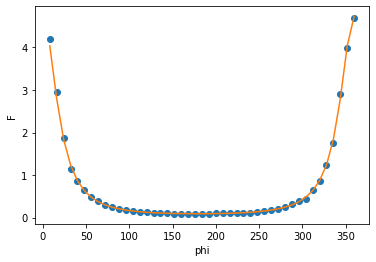

CFFs: [ 0.72767914 -5.62357543  3.55266341]


In [62]:
plot_curve(0, data, results)

## Set 2

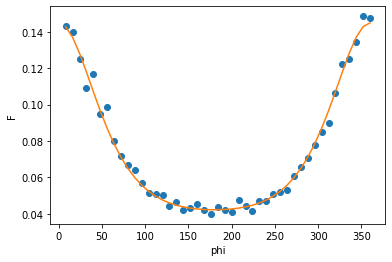

CFFs: [ 1.459959   -4.20087806  6.05438172]


In [63]:
plot_curve(1, data, results)

## Set 3

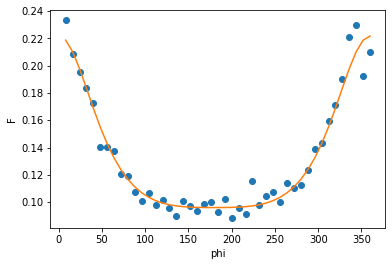

CFFs: [ 1.88443426 -2.97530387  5.65428785]


In [64]:
plot_curve(2, data, results)

## Set 4

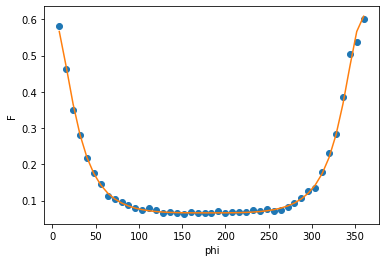

CFFs: [0.59455426 9.91325047 0.95335303]


In [65]:
plot_curve(3, data, results)

## Set 5

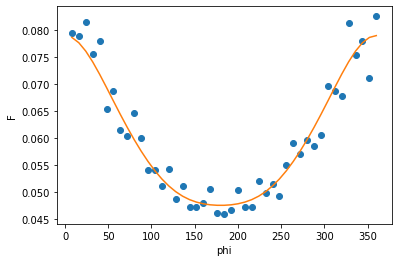

CFFs: [   84.64503419 -1184.43238742   653.07922152]


In [66]:
plot_curve(4, data, results)

# Overall RMSE

In [77]:
sse = 0
for i in range(results.shape[0]):
    cffs = results[i, :, :].mean(axis=0)
    seti = data.getSet(i)
    X = np.array(seti.X)
    y = seti.y
    yhat = bhdvcs.TotalUUXS(X, *cffs).numpy()
    sse += np.sqrt(((yhat - y)**2).mean())

In [78]:
sse/len(np.unique(data.df['#Set']))

0.0022778371231849674

## R-Squared

In [79]:
sumr2s = 0
for i in range(results.shape[0]):
    cffs = results[i, :, :].mean(axis=0)
    seti = data.getSet(i)
    X = np.array(seti.X)
    y = seti.y
    yhat = bhdvcs.TotalUUXS(X, *cffs).numpy()
    tss = ((yhat - y.mean())**2).sum()
    rss = ((y - yhat)**2).sum()
    sumr2s += 1 - rss/tss

In [80]:
sumr2s/len(np.unique(data.df['#Set']))

0.9643192565711194

# Save Results to file for later use

In [26]:
results.tofile('replicas100.txt')

In [21]:
reps = np.fromfile('replicas100.txt')

In [27]:
reps = reps.reshape((342, 100, 3))

In [33]:
repsdf = pd.DataFrame({'Set#': np.zeros(342*100), 'RepNum': np.zeros(342*100), 'ReH': np.zeros(342*100),
                       'ReE': np.zeros(342*100), 'ReHtilde': np.zeros(342*100)})

In [51]:
repsdf['ReH'] = reps[:, :, 0].flatten('F')
repsdf['ReE'] = reps[:, :, 1].flatten('F')
repsdf['ReHtilde'] = reps[:, :, 2].flatten('F')

In [56]:
repsdf['Set#'] = np.repeat(np.arange(1, 343), 100)

In [58]:
repsdf['RepNum'] = np.tile(np.arange(0, 100), 342)

In [60]:
repsdf.to_csv('ExampleDataFile.csv')